<a href="https://colab.research.google.com/github/micahke/add-gpt3-notes/blob/master/MLTestipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 844 kB/s 
     |████████████████████████████████| 40 kB 4.1 MB/s 
     |████████████████████████████████| 16.0 MB 1.3 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 185 kB 40.2 MB/s 
     |████████████████████████████████| 237 kB 40.2 MB/s 
     |████████████████████████████████| 145 kB 47.3 MB/s 
     |████████████████████████████████| 51 kB 6.1 MB/s 
     |████████████████████████████████| 1.7 MB 37.2 MB/s 
     |████████████████████████████████| 5.9 MB 37.3 MB/s 
     |████████████████████████████████| 438 kB 45.7 MB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Att

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Check the version of Tensorflow:

In [ ]:
print(tf.__version__)

2.10.0


# Prepare the Data

### Create a data set

In [ ]:
raw_dataset = pd.read_csv('fragmentData.csv')
raw_dataset.pop('timestamp')
raw_dataset.pop('file_type')

# raw_dataset['file_size_bytes'] = raw_dataset['file_size_bytes']**(1/6)
# raw_dataset['upload_speed_bytes'] = raw_dataset['upload_speed_bytes']**(1/6)
# raw_dataset['upload_time'] = raw_dataset['upload_time']**(1/6)
# raw_dataset['split_size'] = raw_dataset['split_size']**(1/6)

dataset = raw_dataset.copy()
dataset.tail()

,file_size_bytes,upload_speed_bytes,upload_time,split_size
776,398458880,153846153,179504,15728640
777,398458880,111111111,160268,18350080
778,398458880,117647058,168478,20971520
779,398458880,133333333,159662,23592960
780,398458880,131147540,181938,26214400


### Clean the data

### Split the data into test and training

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### See some stats

In [ ]:
train_stats = train_dataset.astype(float).describe()
train_stats.pop('upload_time')
train_stats = train_stats.transpose()
train_stats.to_csv('tst.csv')

### Split features from labels

In [ ]:
train_labels = train_dataset.pop('upload_time')
test_labels = test_dataset.pop('upload_time')

### Normalize the data

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

train_stats['mean']
train_stats['std']

file_size_bytes       1.075041e+08
upload_speed_bytes    3.775401e+07
split_size            6.819796e+06
Name: std, dtype: float64

# Build Model

In [ ]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

# Inspect Model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


### Try out the model

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 137ms/step


array([[-0.12924375],
       [ 0.03202555],
       [ 0.04681261],
       [-0.12791066],
       [ 0.06409411],
       [ 0.21219034],
       [ 0.18271741],
       [ 0.05959805],
       [-0.07421161],
       [-0.24099499]], dtype=float32)

# Train the Model

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print(f'EPOCH: {epoch}')


## early stop:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 500
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)

EPOCH: 0
EPOCH: 100
EPOCH: 200
EPOCH: 300
EPOCH: 400


### See history stats

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,137299376.0,5971.152832,137299376.0,161322592.0,6292.600586,161322592.0,495
496,137242384.0,5961.194824,137242384.0,161302880.0,6290.808594,161302880.0,496
497,137318752.0,5981.266113,137318752.0,161359072.0,6312.189941,161359072.0,497
498,137385440.0,5997.013184,137385440.0,161284304.0,6327.883789,161284304.0,498
499,137180176.0,5981.458496,137180176.0,161250848.0,6304.260742,161250848.0,499


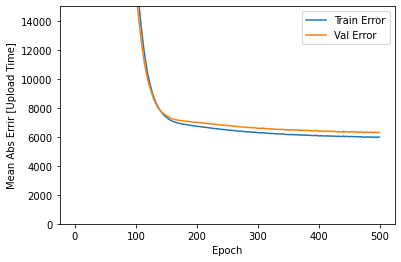

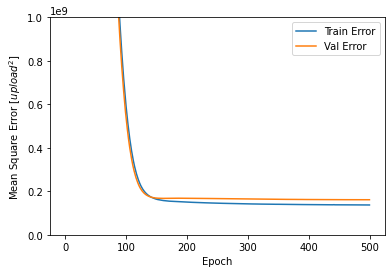

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Errir [Upload Time]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.legend()
  plt.ylim(0, 15000)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$upload^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.legend()
  plt.ylim(0, 1000000000)

plot_history(history)

# Test the Model

5/5 [==============================] - 0s 3ms/step


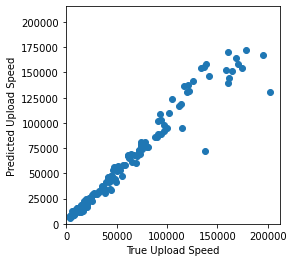

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Upload Speed')
plt.ylabel('Predicted Upload Speed')
plt.axis('equal')
plt.axis('square')
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])
_ = plt.plot([-100, 100], [-100, 100])

Check Error:

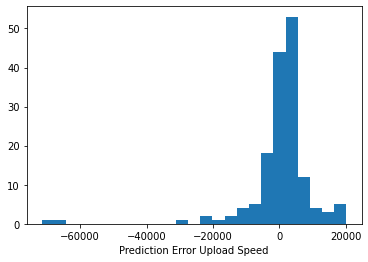

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error Upload Speed')
_ = plt.ylabel

In [ ]:
# model.predict(normed_test_data[:1])
cols = [
    'file_size_bytes',
    'upload_speed_bytes',
    'split_size'
]
newData = [[
    408944640,
    148148148,
    15000000
]]
new_df = pd.DataFrame(data=newData, columns=cols)
new_df = norm(new_df)
model.predict(new_df)
model.summary()

1/1 [==============================] - 0s 25ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


# Save the model

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'sample_data')